# Preliminary ML Model

In [26]:
import pandas as pd
import numpy as np
import hvplot.pandas
import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from random import sample

play_injuries = pd.read_csv('play_injuries_inner.csv')
# Play Key is just an identifier
play_injuries.drop(columns='PlayKey', inplace=True)
play_injuries.head()

,PlayerDay,PlayerGame,FieldType,Temperature,PlayerGamePlay,Injury_Duration,StadiumType,Weather,PlayType,RosterPosition,Position,BodyPart
0,15,3,Natural,89,7,42,Outdoor,Clear,Rush,RB,RB,Knee
1,365,8,Natural,81,15,28,Outdoor,Cloudy,Pass,TE,TE,Foot
2,393,19,Natural,79,7,28,Outdoor,Cloudy,Rush,S,FS,Knee
3,39,5,Natural,48,9,7,Outdoor,Cloudy,Kickoff,WR,WR,Knee
4,389,15,Natural,79,35,7,Outdoor,Clear,Pass,OL,T,Knee


In [25]:
play_injuries.shape

(69, 13)

This may be an issue now, as the rows fall smaller than 1000 for the ML model - this will ultimately be a big problem with this line of analysis, since there were fewer than 200 injuries in the injury dataset

<AxesSubplot:title={'center':'Player Day Density'}, ylabel='Density'>

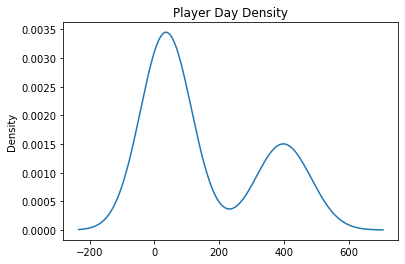

In [5]:
play_injuries.PlayerDay.plot.density(title="Player Day Density")

<AxesSubplot:title={'center':'Player Game Density Plot'}, ylabel='Density'>

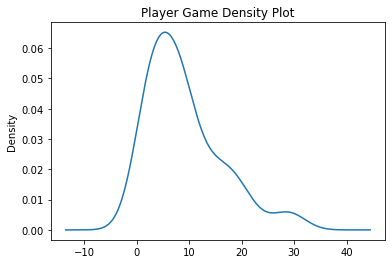

In [6]:
# PlayerGame Plot Density
play_injuries.PlayerGame.plot.density(title="Player Game Density Plot")

In [7]:
# play_injuries.FieldType.plot.density(title='Field Type Density')

<AxesSubplot:title={'center':'Player Game Play Density'}, ylabel='Density'>

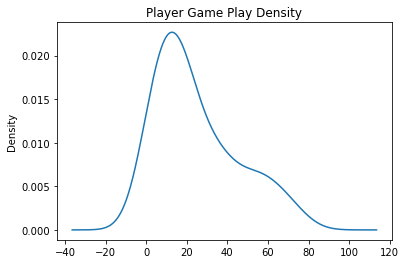

In [8]:
play_injuries.PlayerGamePlay.plot.density(title="Player Game Play Density")

<AxesSubplot:title={'center':'Injury Duration Density'}, ylabel='Density'>

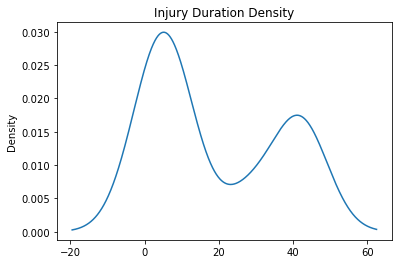

In [9]:
# Because there are so many more non-injuries than injured days, the density plot doesn't 
# show anything useful with the single spike at 0, so all non-injuries are removed
play_injuries.Injury_Duration[play_injuries.Injury_Duration != 0].plot.density(title="Injury Duration Density")

This is an interesting finding, in that most injuries were either short term, under 7 days or long term, extending to 42+ days

### Encode the object datasets

In [10]:
# Generate our categorical variable lists
play_injuries_categorical = play_injuries.dtypes[play_injuries.dtypes == 'object'].index.tolist()

The current dataset it too big to create dummies for, and would require 60 Gb of memory... So creating a random subset

In [12]:
# Use get_dummies() to create variables for the text features
X = pd.get_dummies(play_injuries, columns=play_injuries_categorical)

### Use PCA to reduce dimentions to three principal components

In [13]:
X_pca = PCA(n_components=3).fit_transform(X)

In [14]:
# Create a DF with the three principal components
pcs_df = pd.DataFrame(data = X_pca, columns=['PC 1', 'PC 2', 'PC 3'])
pcs_df = pcs_df.set_index(play_injuries.index)
pcs_df.head()

,PC 1,PC 2,PC 3
0,-138.389954,-5.105241,31.189757
1,211.905243,-5.800358,21.937755
2,240.174546,-13.431445,24.593213
3,-113.181297,-19.526732,-11.974173
4,236.764509,4.707655,-4.243791


### Find Value for K with an Elbow Curve

In [15]:
inertia = []
k = list(range(1, 11))

for i in k:
    km = KMeans(n_clusters = i, random_state = 0)
    km.fit(pcs_df)
    inertia.append(km.inertia_)

elbow_data = {"k": k, 'inertia': inertia}
df_elbow = pd.DataFrame(elbow_data)
df_elbow.hvplot.line(x='k', y='inertia', title='Elbow Curve', xticks=k)

c:\Users\justi\anaconda3\envs\mlenv\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  "KMeans is known to have a memory leak on Windows "


:Curve   [k]   (inertia)

### There is a distinct elbowing event at k=2


In [16]:
# Initialize the k-means model
model = KMeans(n_clusters=2, random_state = 5)

# Fit the model
model.fit(pcs_df)

# Predict the clusters
predictions = model.predict(pcs_df)
print(predictions)

[0 1 1 0 1 0 0 1 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 1 0 1 1 1 0 0 0 0 0 0 1 1
 0 0 1 1 0 0 0 0 0 0 1 0 0 1 0 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0]


## Create a new DF with the PCA Analysis Results as Columns

In [17]:
# Concatenate the data with the Play_Injuries dataframe
clustered_play_injuries = pd.concat([play_injuries, pcs_df], axis=1)

In [18]:
# Add new column for the "Class", based on the predictions
clustered_play_injuries['Class'] = predictions


In [19]:
print(clustered_play_injuries.shape)
clustered_play_injuries.head()


(69, 17)


,PlayKey,PlayerDay,PlayerGame,FieldType,Temperature,PlayerGamePlay,Injury_Duration,StadiumType,Weather,PlayType,RosterPosition,Position,BodyPart,PC 1,PC 2,PC 3,Class
0,31070-3-7,15,3,Natural,89,7,42,Outdoor,Clear,Rush,RB,RB,Knee,-138.389954,-5.105241,31.189757,0
1,33337-8-15,365,8,Natural,81,15,28,Outdoor,Cloudy,Pass,TE,TE,Foot,211.905243,-5.800358,21.937755,1
2,33474-19-7,393,19,Natural,79,7,28,Outdoor,Cloudy,Rush,S,FS,Knee,240.174546,-13.431445,24.593213,1
3,34347-5-9,39,5,Natural,48,9,7,Outdoor,Cloudy,Kickoff,WR,WR,Knee,-113.181297,-19.526732,-11.974173,0
4,35570-15-35,389,15,Natural,79,35,7,Outdoor,Clear,Pass,OL,T,Knee,236.764509,4.707655,-4.243791,1


## Cluster Visualization 

In [20]:
fig = px.scatter_3d(
    clustered_play_injuries,
    x = "PC 1", 
    y = "PC 2", 
    z = "PC 3", 
    color='Class', 
    symbol='Class', 
    width=1200,
    height=1000, 
    title="3D Scatter Using PCA Parameters and K-Means Clustering On NFL Injury data", 
    hover_name = "FieldType", 
    hover_data=[clustered_play_injuries.Injury_Duration, 
        clustered_play_injuries.Position,
        clustered_play_injuries.Weather,
        clustered_play_injuries.PlayType,
        clustered_play_injuries.StadiumType,
        clustered_play_injuries.BodyPart,
        clustered_play_injuries.RosterPosition,
        clustered_play_injuries.Temperature]
)

fig.update_layout(legend=dict(x=0, y=1))
fig.show()

## Analyze the data by class

In [21]:
injury_subset_0 = clustered_play_injuries[clustered_play_injuries.Class == 0]
injury_subset_1 = clustered_play_injuries[clustered_play_injuries.Class == 1]

In [23]:
injury_subset_0

,PlayKey,PlayerDay,PlayerGame,FieldType,Temperature,PlayerGamePlay,Injury_Duration,StadiumType,Weather,PlayType,RosterPosition,Position,BodyPart,PC 1,PC 2,PC 3,Class
0,31070-3-7,15,3,Natural,89,7,42,Outdoor,Clear,Rush,RB,RB,Knee,-138.389954,-5.105241,31.189757,0
3,34347-5-9,39,5,Natural,48,9,7,Outdoor,Cloudy,Kickoff,WR,WR,Knee,-113.181297,-19.526732,-11.974173,0
5,35611-7-42,50,7,Synthetic,68,42,7,Indoor,Indoor,Pass,S,FS,Ankle,-101.940284,12.542136,-18.183379,0
6,36557-1-70,1,1,Synthetic,63,70,42,Outdoor,Clear,Pass,S,SS,Ankle,-151.173138,51.294156,-0.456303,0
9,38192-8-8,57,8,Natural,61,8,1,Outdoor,Cloudy,Pass,WR,WR,Ankle,-95.202912,-21.742749,-12.669695,0
10,38228-1-4,1,1,Synthetic,65,4,7,Outdoor,Cloudy,Punt,LB,ILB,Ankle,-151.601786,-22.617341,-5.802843,0
11,38364-5-23,29,5,Synthetic,76,23,42,Outdoor,Cloudy,Kickoff,WR,WR,Foot,-123.918433,8.629261,21.579731,0
13,39678-2-1,8,2,Synthetic,78,1,42,Open Dome,Clear,Rush,DL,DE,Ankle,-145.343644,-11.462873,30.024115,0
14,39850-9-2,64,9,Synthetic,47,2,42,Outdoor,Cloudy,Punt,S,SS,Knee,-88.694577,-13.240149,21.487017,0
15,39873-4-32,29,4,Synthetic,84,32,42,Indoor,Cloudy,Punt,LB,OLB,Knee,-123.941407,17.563229,20.639635,0


In [24]:
injury_subset_1

,PlayKey,PlayerDay,PlayerGame,FieldType,Temperature,PlayerGamePlay,Injury_Duration,StadiumType,Weather,PlayType,RosterPosition,Position,BodyPart,PC 1,PC 2,PC 3,Class
1,33337-8-15,365,8,Natural,81,15,28,Outdoor,Cloudy,Pass,TE,TE,Foot,211.905243,-5.800358,21.937755,1
2,33474-19-7,393,19,Natural,79,7,28,Outdoor,Cloudy,Rush,S,FS,Knee,240.174546,-13.431445,24.593213,1
4,35570-15-35,389,15,Natural,79,35,7,Outdoor,Clear,Pass,OL,T,Knee,236.764509,4.707655,-4.243791,1
7,36559-12-65,365,12,Natural,58,65,7,Outdoor,Rain,Pass,CB,CB,Knee,213.414303,30.980810,-22.237066,1
8,36607-16-19,422,16,Synthetic,74,19,42,Indoor,Clear,Pass,LB,ILB,Knee,269.070050,2.254330,31.720536,1
12,38876-29-14,471,29,Natural,58,14,7,Outdoor,Rain,Punt Returned,WR,WR,Ankle,319.177099,-16.758772,-1.195335,1
19,41113-15-63,421,15,Natural,53,63,1,Outdoor,Clear,Rush,LB,OLB,Ankle,269.602128,26.173721,-26.971138,1
23,42348-23-53,406,23,Synthetic,46,53,28,Outdoor,Cloudy,Rush,LB,OLB,Knee,254.432474,26.552872,-2.318610,1
24,42398-15-33,396,15,Synthetic,70,33,42,Outdoor,Rain,Punt Returned,WR,WR,Knee,243.318822,15.054536,24.673043,1
26,42418-19-15,442,19,Synthetic,57,15,1,Closed Dome,Cloudy,Rush,OL,C,Ankle,289.979947,-18.043886,-7.423768,1


Just based on first glance, these data are split solely on PlayerDay - which is just 2016 vs 2017. Will remove this column and rerun the PCA.

### Next Run

In [28]:
play_injuries = pd.read_csv('play_injuries_inner.csv')
play_injuries.drop(columns=["PlayKey", "PlayerDay"], inplace=True)
play_injuries.head()


,PlayerGame,FieldType,Temperature,PlayerGamePlay,Injury_Duration,StadiumType,Weather,PlayType,RosterPosition,Position,BodyPart
0,3,Natural,89,7,42,Outdoor,Clear,Rush,RB,RB,Knee
1,8,Natural,81,15,28,Outdoor,Cloudy,Pass,TE,TE,Foot
2,19,Natural,79,7,28,Outdoor,Cloudy,Rush,S,FS,Knee
3,5,Natural,48,9,7,Outdoor,Cloudy,Kickoff,WR,WR,Knee
4,15,Natural,79,35,7,Outdoor,Clear,Pass,OL,T,Knee


In [29]:
# Generate our categorical variable lists
play_injuries_categorical = play_injuries.dtypes[play_injuries.dtypes == 'object'].index.tolist()

# Use get_dummies() to create variables for the text features
X = pd.get_dummies(play_injuries, columns=play_injuries_categorical)

X_pca = PCA(n_components=3).fit_transform(X)

# Create a DF with the three principal components
pcs_df = pd.DataFrame(data=X_pca, columns=['PC 1', 'PC 2', 'PC 3'])
pcs_df = pcs_df.set_index(play_injuries.index)
pcs_df.head()

,PC 1,PC 2,PC 3
0,-7.830629,36.138803,-10.131573
1,-5.250892,17.770756,-9.189019
2,-12.493284,17.836980,-5.246369
3,-19.780885,-11.241868,11.602781
4,6.635204,-8.060229,-17.615638


In [30]:
# Find k-value with elbow curve
inertia = []
k = list(range(1, 11))

for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(pcs_df)
    inertia.append(km.inertia_)

elbow_data = {"k": k, 'inertia': inertia}
df_elbow = pd.DataFrame(elbow_data)
df_elbow.hvplot.line(x='k', y='inertia', title='Elbow Curve', xticks=k)


c:\Users\justi\anaconda3\envs\mlenv\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



:Curve   [k]   (inertia)

The New Elbow is either 3 or 6

### The 3 - Means Model

In [31]:
# Initialize the k-means model
model = KMeans(n_clusters=3, random_state=5)

# Fit the model
model.fit(pcs_df)

# Predict the clusters
predictions = model.predict(pcs_df)
print(predictions)


[1 1 1 0 0 2 2 2 1 0 0 1 0 1 1 1 0 0 2 2 2 0 0 2 1 0 0 1 2 1 1 2 2 0 1 0 2
 1 0 0 1 1 1 2 0 2 0 0 0 2 0 1 2 0 0 0 0 2 0 0 1 0 0 2 0 0 0 0 0]


In [32]:
# Concatenate the data with the Play_Injuries dataframe
clustered_play_injuries = pd.concat([play_injuries, pcs_df], axis=1)

# Add new column for the "Class", based on the predictions
clustered_play_injuries['Class'] = predictions


In [33]:
fig = px.scatter_3d(
    clustered_play_injuries,
    x="PC 1",
    y="PC 2",
    z="PC 3",
    color='Class',
    symbol='Class',
    width=1200,
    height=1000,
    title="3D Scatter Using PCA Parameters and K-Means Clustering On NFL Injury data",
    hover_name="FieldType",
    hover_data=[clustered_play_injuries.Injury_Duration,
                clustered_play_injuries.Position,
                clustered_play_injuries.Weather,
                clustered_play_injuries.PlayType,
                clustered_play_injuries.StadiumType,
                clustered_play_injuries.BodyPart,
                clustered_play_injuries.RosterPosition,
                clustered_play_injuries.Temperature]
)

fig.update_layout(legend=dict(x=0, y=1))
fig.show()


In [34]:
injury_subset_0 = clustered_play_injuries[clustered_play_injuries.Class == 0]
injury_subset_1 = clustered_play_injuries[clustered_play_injuries.Class == 1]
injury_subset_2 = clustered_play_injuries[clustered_play_injuries.Class == 2]
# injury_subset_3 = clustered_play_injuries[clustered_play_injuries.Class == 3]
# injury_subset_4 = clustered_play_injuries[clustered_play_injuries.Class == 4]
# injury_subset_5 = clustered_play_injuries[clustered_play_injuries.Class == 5]


In [36]:
injury_subset_0

,PlayerGame,FieldType,Temperature,PlayerGamePlay,Injury_Duration,StadiumType,Weather,PlayType,RosterPosition,Position,BodyPart,PC 1,PC 2,PC 3,Class
3,5,Natural,48,9,7,Outdoor,Cloudy,Kickoff,WR,WR,Knee,-19.780885,-11.241868,11.602781,0
4,15,Natural,79,35,7,Outdoor,Clear,Pass,OL,T,Knee,6.635204,-8.060229,-17.615638,0
9,8,Natural,61,8,1,Outdoor,Cloudy,Pass,WR,WR,Ankle,-21.941890,-11.000269,-2.067570,0
10,1,Synthetic,65,4,7,Outdoor,Cloudy,Punt,LB,ILB,Ankle,-23.724507,-1.973313,-3.477359,0
12,29,Natural,58,14,7,Outdoor,Rain,Punt Returned,WR,WR,Ankle,-13.707656,-12.253558,5.013712,0
16,2,Natural,68,14,7,Outdoor,Cloudy,Pass,S,FS,Knee,-14.132693,-4.051365,-7.112926,0
17,1,Synthetic,70,8,1,Indoor,Indoor,Kickoff,LB,OLB,Knee,-21.719554,-6.176156,-10.915383,0
21,9,Synthetic,42,9,7,Outdoor,Cloudy,Rush,LB,OLB,Ankle,-19.938881,-14.340207,17.440874,0
22,1,Natural,70,12,7,Outdoor,Clear,Rush,LB,OLB,Ankle,-15.942294,-2.434641,-8.805151,0
25,6,Synthetic,75,13,1,Outdoor,Cloudy,Pass,OL,C,Ankle,-16.575126,-6.443308,-15.306554,0


- All of the injuries in this group are relatively minor, resulting injuries less than 28 days 
- The game plays in this group are all under play 35
- There is a broad temperature range
- All but 4 of them were outdoor conditions
- More of these injuries were on Natural Fields
- There were no foot injuries in this group

In [37]:
injury_subset_1

,PlayerGame,FieldType,Temperature,PlayerGamePlay,Injury_Duration,StadiumType,Weather,PlayType,RosterPosition,Position,BodyPart,PC 1,PC 2,PC 3,Class
0,3,Natural,89,7,42,Outdoor,Clear,Rush,RB,RB,Knee,-7.830629,36.138803,-10.131573,1
1,8,Natural,81,15,28,Outdoor,Cloudy,Pass,TE,TE,Foot,-5.250892,17.770756,-9.189019,1
2,19,Natural,79,7,28,Outdoor,Cloudy,Rush,S,FS,Knee,-12.493284,17.836980,-5.246369,1
8,16,Synthetic,74,19,42,Indoor,Clear,Pass,LB,ILB,Knee,3.133926,24.146796,3.512741,1
11,5,Synthetic,76,23,42,Outdoor,Cloudy,Kickoff,WR,WR,Foot,6.600563,25.345811,0.005677,1
13,2,Synthetic,78,1,42,Open Dome,Clear,Rush,DL,DE,Ankle,-14.064539,33.605352,0.203705,1
14,9,Synthetic,47,2,42,Outdoor,Cloudy,Punt,S,SS,Knee,-14.499413,19.322465,28.574102,1
15,4,Synthetic,84,32,42,Indoor,Cloudy,Punt,LB,OLB,Knee,15.434013,25.981581,-8.209325,1
24,15,Synthetic,70,33,42,Outdoor,Rain,Punt Returned,WR,WR,Knee,16.035020,18.172262,5.479524,1
27,14,Synthetic,78,3,28,Open Dome,Cloudy,Pass,WR,WR,Knee,-16.471476,19.444858,-4.518047,1


- All of the injuries in this group are longer-term injuries, all exceeding 28 days
- Temperature was all over the place
- Only 3 were indoor conditions
- There seem to be more of these injuries on synthetic fields

In [38]:
injury_subset_2

,PlayerGame,FieldType,Temperature,PlayerGamePlay,Injury_Duration,StadiumType,Weather,PlayType,RosterPosition,Position,BodyPart,PC 1,PC 2,PC 3,Class
5,7,Synthetic,68,42,7,Indoor,Indoor,Pass,S,FS,Ankle,12.368564,-13.679787,-9.501661,2
6,1,Synthetic,63,70,42,Outdoor,Clear,Pass,S,SS,Ankle,49.973098,5.600440,6.103493,2
7,12,Natural,58,65,7,Outdoor,Rain,Pass,CB,CB,Knee,33.630284,-25.896795,-2.446182,2
18,1,Natural,72,55,42,Outdoor,Clear,Pass,S,SS,Knee,36.335124,14.113155,-0.332115,2
19,15,Natural,53,63,1,Outdoor,Clear,Rush,LB,OLB,Ankle,29.575222,-32.815079,0.033806,2
20,2,Natural,89,60,1,Outdoor,Clear,Pass,S,SS,Knee,28.183612,-14.914657,-33.279881,2
23,23,Synthetic,46,53,28,Outdoor,Cloudy,Rush,LB,OLB,Knee,29.157370,-11.095215,19.755093,2
28,20,Synthetic,73,76,28,Open Dome,Clear,Rush,CB,CB,Ankle,52.093460,-6.698202,-7.131325,2
31,2,Natural,68,49,42,Outdoor,Cloudy,Pass,OL,C,Foot,30.515096,14.196792,3.989567,2
32,5,Synthetic,89,69,42,Open Dome,Cloudy,Kickoff,WR,WR,Ankle,50.506106,16.172861,-16.498020,2


- There is no pattern to the Injury duration
- There is no correlation with the Field Type
- Again, all but 1 are outdoor stadiums
- It appears that most of these injuries were during passing playes
- A large proportion of these injuries were to the Safety 
- Only 1 of the plays in this group was a Punt play

### The 6-Means Model

In [46]:
# Initialize the k-means model
model = KMeans(n_clusters=6, random_state=5)

# Fit the model
model.fit(pcs_df)

# Predict the clusters
predictions = model.predict(pcs_df)

# Concatenate the data with the Play_Injuries dataframe
clustered_play_injuries = pd.concat([play_injuries, pcs_df], axis=1)

# Add new column for the "Class", based on the predictions
clustered_play_injuries['Class'] = predictions


In [47]:
injury_subset_0 = clustered_play_injuries[clustered_play_injuries.Class == 0]
injury_subset_1 = clustered_play_injuries[clustered_play_injuries.Class == 1]
injury_subset_2 = clustered_play_injuries[clustered_play_injuries.Class == 2]
injury_subset_3 = clustered_play_injuries[clustered_play_injuries.Class == 3]
injury_subset_4 = clustered_play_injuries[clustered_play_injuries.Class == 4]
injury_subset_5 = clustered_play_injuries[clustered_play_injuries.Class == 5]


In [48]:
fig = px.scatter_3d(
    clustered_play_injuries,
    x="PC 1",
    y="PC 2",
    z="PC 3",
    color='Class',
    symbol='Class',
    width=1200,
    height=1000,
    title="3D Scatter Using PCA Parameters and K-Means Clustering On NFL Injury data",
    hover_name="FieldType",
    hover_data=[clustered_play_injuries.Injury_Duration,
                clustered_play_injuries.Position,
                clustered_play_injuries.Weather,
                clustered_play_injuries.PlayType,
                clustered_play_injuries.StadiumType,
                clustered_play_injuries.BodyPart,
                clustered_play_injuries.RosterPosition,
                clustered_play_injuries.Temperature]
)

fig.update_layout(legend=dict(x=0, y=1))
fig.show()


In [49]:
injury_subset_0

,PlayerGame,FieldType,Temperature,PlayerGamePlay,Injury_Duration,StadiumType,Weather,PlayType,RosterPosition,Position,BodyPart,PC 1,PC 2,PC 3,Class
3,5,Natural,48,9,7,Outdoor,Cloudy,Kickoff,WR,WR,Knee,-19.780885,-11.241868,11.602781,0
12,29,Natural,58,14,7,Outdoor,Rain,Punt Returned,WR,WR,Ankle,-13.707656,-12.253558,5.013712,0
21,9,Synthetic,42,9,7,Outdoor,Cloudy,Rush,LB,OLB,Ankle,-19.938881,-14.340207,17.440874,0
26,19,Synthetic,57,15,1,Closed Dome,Cloudy,Rush,OL,C,Ankle,-15.182725,-16.509549,2.067207,0
38,6,Natural,52,13,1,Outdoor,Rain,Pass,WR,WR,Knee,-17.783432,-16.037913,5.187131,0
44,13,Natural,44,20,7,Outdoor,Clear,Pass,WR,WR,Ankle,-9.352402,-17.607191,14.944254,0
48,8,Natural,38,18,1,Outdoor,Clear,Punt,S,FS,Ankle,-13.736586,-23.757359,17.373235,0
54,17,Synthetic,39,27,1,Outdoor,Rain,Rush,WR,WR,Ankle,-4.913106,-27.534959,16.604224,0
58,18,Synthetic,45,3,7,Outdoor,Cloudy,Kickoff Returned,TE,TE,Knee,-25.110241,-12.518872,16.482986,0
59,8,Natural,38,6,7,Outdoor,Clear,Punt,LB,MLB,Knee,-23.008962,-14.903644,21.196169,0


- All under 28 days 
- Only 1 Indoor
- All Plays at or under 27
- Ankle and Knee only
- All temperatures under 60 degrees
- Equal Natural:Synthetic
- Mix of plays


In [50]:
injury_subset_1

,PlayerGame,FieldType,Temperature,PlayerGamePlay,Injury_Duration,StadiumType,Weather,PlayType,RosterPosition,Position,BodyPart,PC 1,PC 2,PC 3,Class
14,9,Synthetic,47,2,42,Outdoor,Cloudy,Punt,S,SS,Knee,-14.499413,19.322465,28.574102,1
30,3,Natural,33,6,42,Outdoor,Clear,Punt,LB,OLB,Knee,-11.688425,13.104187,39.896326,1
37,10,Natural,38,31,42,Outdoor,Clear,Pass,DL,DE,Foot,12.324386,6.212459,33.609273,1
40,20,Synthetic,39,21,42,Outdoor,Clear,Rush,DL,DT,Knee,3.324470,8.322887,34.988106,1
41,11,Synthetic,46,32,42,Outdoor,Cloudy,Pass,LB,OLB,Ankle,13.715093,9.078916,26.497836,1
51,10,Synthetic,60,22,42,Open Dome,Clear,Rush,RB,RB,Ankle,5.015806,18.253933,14.957835,1


- All long-term injuries over 42 days
- Temperatures mostly in the 30s and 40s
- Play numbers all under 35 - so early game
- All Outdoor
- Knee, Foot, and Ankle
- Mode Synthetic than Natural (2:1)

In [51]:
injury_subset_2

,PlayerGame,FieldType,Temperature,PlayerGamePlay,Injury_Duration,StadiumType,Weather,PlayType,RosterPosition,Position,BodyPart,PC 1,PC 2,PC 3,Class
4,15,Natural,79,35,7,Outdoor,Clear,Pass,OL,T,Knee,6.635204,-8.060229,-17.615638,2
5,7,Synthetic,68,42,7,Indoor,Indoor,Pass,S,FS,Ankle,12.368564,-13.679787,-9.501661,2
7,12,Natural,58,65,7,Outdoor,Rain,Pass,CB,CB,Knee,33.630284,-25.896795,-2.446182,2
19,15,Natural,53,63,1,Outdoor,Clear,Rush,LB,OLB,Ankle,29.575222,-32.815079,0.033806,2
20,2,Natural,89,60,1,Outdoor,Clear,Pass,S,SS,Knee,28.183612,-14.914657,-33.279881,2
36,12,Natural,61,41,7,Outdoor,Rain,Pass,DL,DE,Knee,11.224683,-17.024112,-2.558147,2
39,28,Synthetic,70,35,1,Indoor,Clear,Pass,WR,WR,Ankle,4.616038,-18.778639,-10.582396,2
45,5,Natural,67,52,7,Outdoor,Cloudy,Rush,LB,OLB,Knee,21.618591,-16.959534,-9.916174,2
49,8,Synthetic,68,40,7,Outdoor,Clear,Pass,WR,WR,Ankle,10.521354,-13.194314,-9.161306,2
52,30,Natural,45,58,7,Outdoor,Clear,Pass,S,FS,Ankle,27.014368,-31.775554,12.026868,2


- All short-term injuries
- Mostly moderate temperatures between 60 and 80
- Game Plays all 35+, later game
- Mostly Outdoor
- Almost all were passing plays
- No Foot Injuries
- Most occurred on Natural fields (7:3)

In [52]:
injury_subset_3

,PlayerGame,FieldType,Temperature,PlayerGamePlay,Injury_Duration,StadiumType,Weather,PlayType,RosterPosition,Position,BodyPart,PC 1,PC 2,PC 3,Class
9,8,Natural,61,8,1,Outdoor,Cloudy,Pass,WR,WR,Ankle,-21.941890,-11.000269,-2.067570,3
10,1,Synthetic,65,4,7,Outdoor,Cloudy,Punt,LB,ILB,Ankle,-23.724507,-1.973313,-3.477359,3
16,2,Natural,68,14,7,Outdoor,Cloudy,Pass,S,FS,Knee,-14.132693,-4.051365,-7.112926,3
17,1,Synthetic,70,8,1,Indoor,Indoor,Kickoff,LB,OLB,Knee,-21.719554,-6.176156,-10.915383,3
22,1,Natural,70,12,7,Outdoor,Clear,Rush,LB,OLB,Ankle,-15.942294,-2.434641,-8.805151,3
25,6,Synthetic,75,13,1,Outdoor,Cloudy,Pass,OL,C,Ankle,-16.575126,-6.443308,-15.306554,3
33,3,Natural,89,14,1,Outdoor,Clear,Rush,LB,MLB,Ankle,-15.019992,-0.476011,-28.261491,3
35,8,Synthetic,62,9,7,Outdoor,Cloudy,Rush,DL,DT,Knee,-18.939001,-5.844236,-0.498379,3
46,7,Natural,70,10,7,Outdoor,Windy,Kickoff,DL,DE,Knee,-17.621500,-2.682565,-7.872803,3
47,9,Natural,81,4,1,Outdoor,Cloudy,Rush,WR,WR,Ankle,-24.630954,-1.538571,-19.349399,3


- All short-term injuries
- All temperatures over 60 with 5 over 78 degrees
- Game Plays all under 35
- Mostly outdoor
- Mix of plays
- No Foot injuries
- More Natural than Synthetic 

In [53]:
injury_subset_4

,PlayerGame,FieldType,Temperature,PlayerGamePlay,Injury_Duration,StadiumType,Weather,PlayType,RosterPosition,Position,BodyPart,PC 1,PC 2,PC 3,Class
6,1,Synthetic,63,70,42,Outdoor,Clear,Pass,S,SS,Ankle,49.973098,5.600440,6.103493,4
18,1,Natural,72,55,42,Outdoor,Clear,Pass,S,SS,Knee,36.335124,14.113155,-0.332115,4
23,23,Synthetic,46,53,28,Outdoor,Cloudy,Rush,LB,OLB,Knee,29.157370,-11.095215,19.755093,4
24,15,Synthetic,70,33,42,Outdoor,Rain,Punt Returned,WR,WR,Knee,16.035020,18.172262,5.479524,4
28,20,Synthetic,73,76,28,Open Dome,Clear,Rush,CB,CB,Ankle,52.093460,-6.698202,-7.131325,4
31,2,Natural,68,49,42,Outdoor,Cloudy,Pass,OL,C,Foot,30.515096,14.196792,3.989567,4
32,5,Synthetic,89,69,42,Open Dome,Cloudy,Kickoff,WR,WR,Ankle,50.506106,16.172861,-16.498020,4
43,5,Synthetic,75,41,28,Outdoor,Cloudy,Pass,LB,MLB,Ankle,18.767592,7.468870,-6.961865,4
57,4,Synthetic,61,44,42,Outdoor,Clear,Pass,S,SS,Ankle,25.542103,12.567331,11.015110,4
63,7,Synthetic,55,55,28,Outdoor,Cloudy,Punt Not Returned,CB,CB,Foot,30.957967,-5.604894,9.619818,4


- All injuries over 28 days
- Broad range of temperatures
- All but 1 Game play over 40, so late game
- All Outdoor
- Mostly knee/ankle injuries with some foot
- Almost all Synthetic 

In [54]:
injury_subset_5

,PlayerGame,FieldType,Temperature,PlayerGamePlay,Injury_Duration,StadiumType,Weather,PlayType,RosterPosition,Position,BodyPart,PC 1,PC 2,PC 3,Class
0,3,Natural,89,7,42,Outdoor,Clear,Rush,RB,RB,Knee,-7.830629,36.138803,-10.131573,5
1,8,Natural,81,15,28,Outdoor,Cloudy,Pass,TE,TE,Foot,-5.250892,17.770756,-9.189019,5
2,19,Natural,79,7,28,Outdoor,Cloudy,Rush,S,FS,Knee,-12.493284,17.836980,-5.246369,5
8,16,Synthetic,74,19,42,Indoor,Clear,Pass,LB,ILB,Knee,3.133926,24.146796,3.512741,5
11,5,Synthetic,76,23,42,Outdoor,Cloudy,Kickoff,WR,WR,Foot,6.600563,25.345811,0.005677,5
13,2,Synthetic,78,1,42,Open Dome,Clear,Rush,DL,DE,Ankle,-14.064539,33.605352,0.203705,5
15,4,Synthetic,84,32,42,Indoor,Cloudy,Punt,LB,OLB,Knee,15.434013,25.981581,-8.209325,5
27,14,Synthetic,78,3,28,Open Dome,Cloudy,Pass,WR,WR,Knee,-16.471476,19.444858,-4.518047,5
29,3,Natural,88,1,42,Outdoor,Clear,Kickoff,LB,OLB,Knee,-13.520897,37.623384,-8.600197,5
34,7,Natural,70,2,42,Outdoor,Cloudy,Pass,LB,MLB,Ankle,-13.374829,29.190163,7.810782,5


- All injuries over 28 days
- Almost all temperatures 70+
- Early game, game plays all under 35
- mostly outdoor
- Mostly knee/ankle some foot injuries
- Equal Synthetic:Natural 

---

# Ideas for Supervised learning:
 
 - what are the predictors to classify short-term/long-term injuries?
 - what are the predictors to classify each duration 1, 7, 28, 42+ day injuries
 - can we predict body part of injury given the input parameters, (excluding duration)